# 영화리뷰 텍스트 감성분석하기

## 0) Install & Import

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev

pip3 install JPype1
pip3 install konlpy
!pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import konlpy
import gensim
from konlpy.tag import Mecab
from collections import Counter

print(konlpy.__version__)
print(gensim.__version__)

0.6.0
3.6.0


In [73]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 1) 데이터 준비와 확인

In [74]:
train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/Exp/09/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/Exp/09/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전 word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [75]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
    train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
    train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
    train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
    train_data = train_data.dropna(how='any') # Null 값 제거

    test_data.drop_duplicates(subset = ['document'], inplace=True)
    test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    test_data['document'] = test_data['document'].str.replace('^ +', "")
    test_data['document'].replace('', np.nan, inplace=True)
    test_data = test_data.dropna(how='any')
    
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(20000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [76]:
tokenizer = Mecab()

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


## 3) 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [77]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2.5 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  13.795479935133466
문장길이 최대 :  83
문장길이 표준편차 :  11.455691867742807
pad_sequences maxlen :  42
전체 문장의 0.9540425750984581%가 maxlen 설정값 이내에 포함됩니다. 


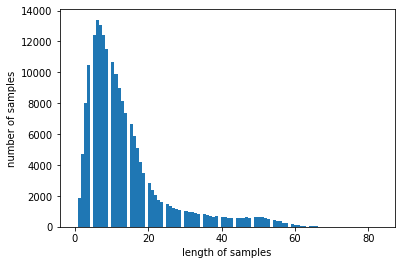

In [78]:
plt.hist([len(s) for s in total_data_text], bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [79]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(145393, 42)


## 4) 모델 구성 및 validation set 구성



*   모델은 3가지 이상 다양하게 구성하여 실험해 보세요.



In [80]:
# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(115393, 42)
(115393,)


In [81]:
vocab_size = len(word_to_index)     # 어휘 사전의 크기
word_vector_dim = 128  # 워드 벡터의 차원수

### 4-1) RNN

In [82]:
# 모델 설계 - 1. RNN
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(word_vector_dim))
model_RNN.add(tf.keras.layers.Dense(64, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_RNN.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 128)         2560000   
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,699,905
Trainable params: 2,699,905
Non-trainable params: 0
_________________________________________________________________


### 4-2) CNN

In [83]:
# 모델 설계 - 2. CNN
model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(word_vector_dim, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(word_vector_dim, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(64, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 128)         2560000   
                                                                 
 conv1d_12 (Conv1D)          (None, None, 128)         114816    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_9 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_32 (Dense)            (None, 64)              

### 4-3) GlobalMaxPooling1D

In [84]:
# 모델 설계 - 3. GlobalMaxPooling1D
model_GMP1D = tf.keras.Sequential()
model_GMP1D.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_GMP1D.add(tf.keras.layers.GlobalMaxPooling1D())
model_GMP1D.add(tf.keras.layers.Dense(64, activation='relu'))
model_GMP1D.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_GMP1D.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, None, 128)         2560000   
                                                                 
 global_max_pooling1d_10 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,568,321
Trainable params: 2,568,321
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

In [97]:
#ealry = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
epochs = 10

In [98]:
#check_RNN = tf.keras.callbacks.ModelCheckpoint('model_RNN.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

model_RNN.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_RNN = model_RNN.fit(partial_X_train,
                            partial_y_train,
                            epochs=epochs,
                            #callbacks=[ealry, check_RNN],
                            batch_size=512,
                            validation_data=(X_val, y_val),
                            verbose=1)

Epoch 1/10
226/226 [==============================] - 62s 262ms/step - loss: 0.1320 - accuracy: 0.9478 - val_loss: 0.5935 - val_accuracy: 0.8391
Epoch 2/10
226/226 [==============================] - 55s 245ms/step - loss: 0.1120 - accuracy: 0.9559 - val_loss: 0.6255 - val_accuracy: 0.8376
Epoch 3/10
226/226 [==============================] - 53s 233ms/step - loss: 0.0979 - accuracy: 0.9615 - val_loss: 0.7252 - val_accuracy: 0.8363
Epoch 4/10
226/226 [==============================] - 51s 227ms/step - loss: 0.0876 - accuracy: 0.9657 - val_loss: 0.7955 - val_accuracy: 0.8370
Epoch 5/10
226/226 [==============================] - 46s 203ms/step - loss: 0.0799 - accuracy: 0.9686 - val_loss: 0.8140 - val_accuracy: 0.8371
Epoch 6/10
226/226 [==============================] - 45s 199ms/step - loss: 0.0730 - accuracy: 0.9719 - val_loss: 0.9147 - val_accuracy: 0.8358
Epoch 7/10
226/226 [==============================] - 44s 197ms/step - loss: 0.0692 - accuracy: 0.9732 - val_loss: 0.9395 - val_ac

In [99]:
#check_CNN = tf.keras.callbacks.ModelCheckpoint('model_CNN.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

model_CNN.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history_CNN = model_CNN.fit(partial_X_train,
                            partial_y_train,
                            epochs=epochs,
                            #callbacks=[ealry, check_CNN],
                            batch_size=512,
                            validation_data=(X_val, y_val),
                            verbose=1)

Epoch 1/10
226/226 [==============================] - 9s 38ms/step - loss: 0.0512 - accuracy: 0.9809 - val_loss: 0.8238 - val_accuracy: 0.8220
Epoch 2/10
226/226 [==============================] - 8s 37ms/step - loss: 0.0389 - accuracy: 0.9843 - val_loss: 0.9794 - val_accuracy: 0.8222
Epoch 3/10
226/226 [==============================] - 8s 37ms/step - loss: 0.0339 - accuracy: 0.9861 - val_loss: 1.0859 - val_accuracy: 0.8219
Epoch 4/10
226/226 [==============================] - 8s 37ms/step - loss: 0.0364 - accuracy: 0.9853 - val_loss: 0.9908 - val_accuracy: 0.8217
Epoch 5/10
226/226 [==============================] - 8s 37ms/step - loss: 0.0328 - accuracy: 0.9867 - val_loss: 0.9829 - val_accuracy: 0.8220
Epoch 6/10
226/226 [==============================] - 9s 38ms/step - loss: 0.0289 - accuracy: 0.9882 - val_loss: 1.1509 - val_accuracy: 0.8201
Epoch 7/10
226/226 [==============================] - 9s 39ms/step - loss: 0.0274 - accuracy: 0.9881 - val_loss: 1.1594 - val_accuracy: 0.8162

In [100]:
#check_GMP1D = tf.keras.callbacks.ModelCheckpoint('model_GMP1D.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

model_GMP1D.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

history_GMP1D = model_GMP1D.fit(partial_X_train,
                                partial_y_train,
                                epochs=epochs,
                                #callbacks=[ealry, check_GMP1D],
                                batch_size=512,
                                validation_data=(X_val, y_val),
                                verbose=1)

Epoch 1/10
226/226 [==============================] - 4s 15ms/step - loss: 0.0482 - accuracy: 0.9857 - val_loss: 0.6674 - val_accuracy: 0.8319
Epoch 2/10
226/226 [==============================] - 3s 14ms/step - loss: 0.0295 - accuracy: 0.9918 - val_loss: 0.7394 - val_accuracy: 0.8278
Epoch 3/10
226/226 [==============================] - 3s 14ms/step - loss: 0.0216 - accuracy: 0.9939 - val_loss: 0.7903 - val_accuracy: 0.8276
Epoch 4/10
226/226 [==============================] - 3s 15ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.8491 - val_accuracy: 0.8259
Epoch 5/10
226/226 [==============================] - 3s 15ms/step - loss: 0.0132 - accuracy: 0.9960 - val_loss: 0.8938 - val_accuracy: 0.8257
Epoch 6/10
226/226 [==============================] - 3s 15ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.9223 - val_accuracy: 0.8253
Epoch 7/10
226/226 [==============================] - 3s 14ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.9625 - val_accuracy: 0.8247

## 6) Loss, Accuracy 그래프 시각화

In [101]:
# 모델 평가 - 1. RNN
#model_RNN_loaded = tf.keras.models.load_model('model_RNN.h5')
#results = model_RNN_loaded.evaluate(X_test,  y_test, verbose=2)
results = model_RNN.evaluate(X_test,  y_test, verbose=2)
print(results)

1527/1527 - 33s - loss: 0.9916 - accuracy: 0.8265 - 33s/epoch - 22ms/step
[0.9916037917137146, 0.8264554142951965]


In [102]:
# 모델 평가 - 2. CNN
#model_CNN_loaded = tf.keras.models.load_model('model_CNN.h5')
#results = model_CNN_loaded.evaluate(X_test,  y_test, verbose=2)
results = model_CNN.evaluate(X_test,  y_test, verbose=2)
print(results)

1527/1527 - 4s - loss: 1.3063 - accuracy: 0.8143 - 4s/epoch - 3ms/step
[1.3063206672668457, 0.8142962455749512]


In [103]:
# 모델 평가 - 3. GlobalMaxPooling1D
#model_GMP1D_loaded = tf.keras.models.load_model('model_GMP1D.h5')
#results = model_GMP1D_loaded.evaluate(X_test,  y_test, verbose=2)
results = model_GMP1D.evaluate(X_test,  y_test, verbose=2)
print(results)

1527/1527 - 2s - loss: 1.0884 - accuracy: 0.8209 - 2s/epoch - 1ms/step
[1.0883997678756714, 0.820887565612793]


In [104]:
# 모델 fitting 간 학습 추세 (accuracy, val_accuracy, loss, val_loss)
history_dict_RNN = history_RNN.history
history_dict_CNN = history_CNN.history
history_dict_GMP1D = history_GMP1D.history

In [105]:
acc_RNN = history_dict_RNN['accuracy']
val_acc_RNN = history_dict_RNN['val_accuracy']
loss_RNN = history_dict_RNN['loss']
val_loss_RNN = history_dict_RNN['val_loss']

acc_CNN = history_dict_CNN['accuracy']
val_acc_CNN = history_dict_CNN['val_accuracy']
loss_CNN = history_dict_CNN['loss']
val_loss_CNN = history_dict_CNN['val_loss']

acc_GMP1D = history_dict_GMP1D['accuracy']
val_acc_GMP1D = history_dict_GMP1D['val_accuracy']
loss_GMP1D = history_dict_GMP1D['loss']
val_loss_GMP1D = history_dict_GMP1D['val_loss']

In [106]:
epochs_plot = range(1, epochs + 1)

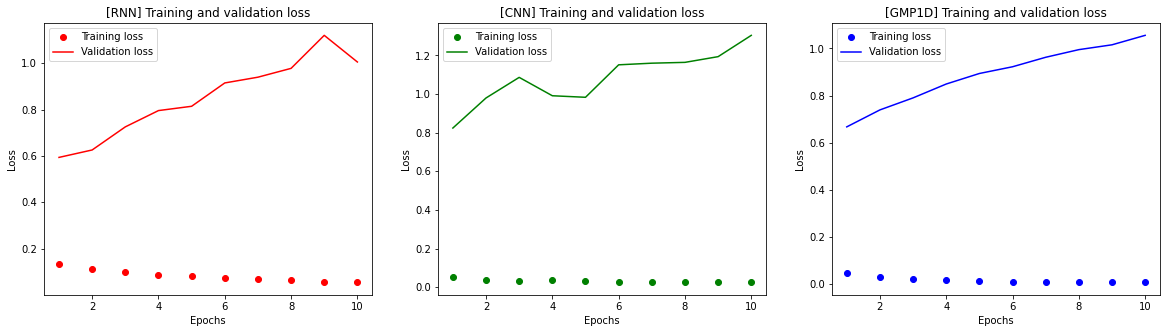

In [107]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(epochs_plot, loss_RNN, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss_RNN, 'r', label='Validation loss')
plt.title('[RNN] Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(epochs_plot, loss_CNN, 'go', label='Training loss')
plt.plot(epochs_plot, val_loss_CNN, 'g', label='Validation loss')
plt.title('[CNN] Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(133)
plt.plot(epochs_plot, loss_GMP1D, 'bo', label='Training loss')
plt.plot(epochs_plot, val_loss_GMP1D, 'b', label='Validation loss')
plt.title('[GMP1D] Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

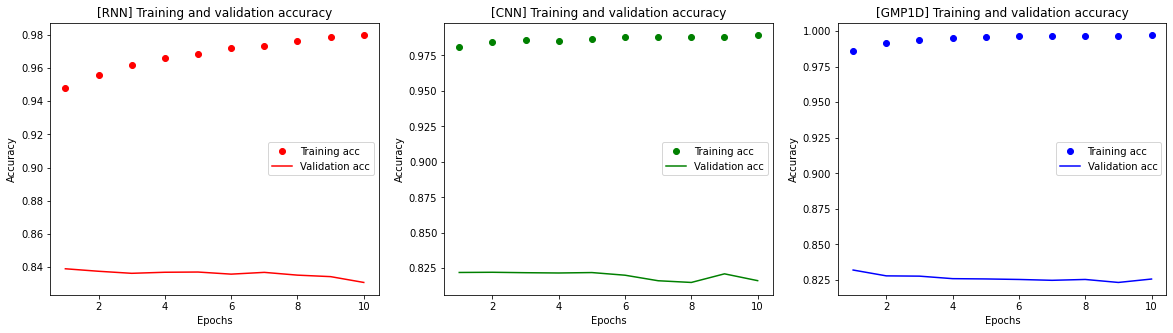

In [108]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(epochs_plot, acc_RNN, 'ro', label='Training acc')
plt.plot(epochs_plot, val_acc_RNN, 'r', label='Validation acc')
plt.title('[RNN] Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(132)
plt.plot(epochs_plot, acc_CNN, 'go', label='Training acc')
plt.plot(epochs_plot, val_acc_CNN, 'g', label='Validation acc')
plt.title('[CNN] Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(epochs_plot, acc_GMP1D, 'bo', label='Training acc')
plt.plot(epochs_plot, val_acc_GMP1D, 'b', label='Validation acc')
plt.title('[GMP1D] Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [116]:
embedding_layer_RNN = model_RNN.layers[0]
weights_RNN = embedding_layer_RNN.get_weights()[0]
print(weights_RNN.shape)
weights_RNN[0]

(20000, 128)


array([-0.03808627,  0.05741218, -0.04039858,  0.00757839,  0.04297548,
       -0.02792334,  0.01043082, -0.04382214, -0.02612838,  0.0333849 ,
       -0.05406142, -0.03353739, -0.0608636 ,  0.04579021,  0.00694404,
        0.0127265 ,  0.01156136,  0.05187907,  0.01417779, -0.03705341,
       -0.0606984 ,  0.02388764,  0.04190844,  0.0202158 , -0.02536291,
        0.00982984,  0.01603248, -0.02776326,  0.00984427, -0.04203201,
       -0.07247858, -0.00098387,  0.03104469,  0.01617973, -0.01230544,
        0.06228898,  0.03269721,  0.04748341,  0.03330855, -0.04398193,
       -0.04675104, -0.04429694,  0.02344408,  0.04865216, -0.02506111,
        0.04390336, -0.04151853,  0.01655661, -0.0254638 ,  0.04884248,
        0.04606576,  0.04946174,  0.00025859,  0.00805449,  0.03469217,
       -0.03084436, -0.05920977, -0.0852403 , -0.05437216,  0.03755643,
        0.04987255,  0.04353659,  0.03616465, -0.00415176, -0.04722396,
       -0.02091205, -0.0566397 , -0.03598792,  0.02630983, -0.04

In [117]:
embedding_layer_CNN = model_CNN.layers[0]
weights_CNN = embedding_layer_CNN.get_weights()[0]
print(weights_CNN.shape)
weights_CNN[0]

(20000, 128)


array([-2.7580639e-02, -1.1791399e-02, -9.4054430e-04,  3.2536527e-03,
       -1.6157955e-02, -1.6942948e-02, -3.6177647e-03,  9.3122190e-03,
        1.3724575e-02,  6.7536635e-03,  9.7779213e-03,  7.5343247e-03,
        4.2360886e-03, -3.6820970e-03, -1.1538416e-02, -1.7276080e-03,
       -1.6452143e-03, -1.6983200e-02, -1.1275701e-02, -1.5655288e-02,
       -1.8056661e-02, -1.3696474e-02,  5.2303979e-03,  3.7225275e-03,
       -1.2238049e-02, -8.3996551e-03, -2.5002635e-03,  4.5208205e-03,
       -1.0690395e-02, -3.2809451e-02,  1.8721085e-02, -1.7371778e-03,
       -1.3680998e-02,  1.2619762e-02, -2.8994686e-03,  1.2162825e-02,
        5.4730423e-05, -2.8630148e-03, -2.9090628e-02, -1.4399555e-02,
        1.1427075e-02,  2.0019386e-02,  1.0674113e-02, -2.2088276e-02,
       -1.2883902e-02,  2.0048067e-02,  1.2468281e-02,  6.0598506e-03,
       -2.6738667e-03,  1.0998760e-02, -5.1297322e-03, -9.6765179e-03,
        1.1748950e-02, -5.1934547e-03, -8.4023895e-03,  1.7270087e-03,
      

In [118]:
embedding_layer_GMP1D = model_GMP1D.layers[0]
weights_GMP1D = embedding_layer_GMP1D.get_weights()[0]
print(weights_GMP1D.shape)
weights_GMP1D[0]

(20000, 128)


array([-0.14184499, -0.20943756, -0.13386635, -0.09399164, -0.09756495,
       -0.23683816, -0.18241112, -0.22011864, -0.19196932, -0.15977263,
       -0.1240866 , -0.08881544, -0.05714576, -0.17483886, -0.13951692,
       -0.09878936, -0.15384203, -0.207146  , -0.15594362, -0.04422931,
       -0.13582408, -0.1532788 , -0.08459337, -0.13834685, -0.14026397,
       -0.13637564, -0.12873371, -0.2734007 , -0.1264116 , -0.2004561 ,
       -0.13500558, -0.11543035, -0.1035714 , -0.13720709, -0.12373361,
       -0.2147629 , -0.15637532, -0.16306216, -0.1671512 , -0.05580549,
       -0.12831126, -0.1445093 , -0.15187052, -0.12051074, -0.21728218,
       -0.15025167, -0.10380352, -0.12971844, -0.12999399, -0.19025357,
       -0.08569966, -0.09893759, -0.16424693, -0.179437  , -0.17089094,
       -0.13758633, -0.12891488, -0.16057721, -0.11592957, -0.05506454,
       -0.09181276, -0.13778456, -0.19418807, -0.10391258, -0.11184172,
       -0.20746946, -0.13626887, -0.1015353 , -0.18892217, -0.15

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [119]:
word2vec_path = '/content/drive/MyDrive/AIFFEL/Exp/09/word2vec/ko.bin'
pre_word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = pre_word2vec['컴퓨터']
vector.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(200,)

In [120]:
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4,vocab_size):
    if index_to_word[i] in pre_word2vec:
        embedding_matrix[i] = pre_word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [121]:
model_ko = tf.keras.Sequential()
model_ko.add(tf.keras.layers.Embedding(vocab_size,
                                       word_vector_dim,
                                       embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                       input_length=maxlen,
                                       trainable=True))
model_ko.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_ko.add(tf.keras.layers.MaxPooling1D(5))
model_ko.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_ko.add(tf.keras.layers.GlobalMaxPooling1D())
model_ko.add(tf.keras.layers.Dense(8, activation='relu'))
model_ko.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_ko.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 42, 200)           4000000   
                                                                 
 conv1d_14 (Conv1D)          (None, 36, 16)            22416     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 7, 16)            0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, 1, 16)             1808      
                                                                 
 global_max_pooling1d_11 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_36 (Dense)            (None, 8)               

In [122]:
# 모델 학습
#check_ko = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

model_ko.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history_ko = model_ko.fit(partial_X_train,
                          partial_y_train,
                          epochs=epochs,
                          #callbacks=[ealry, check_ko],
                          batch_size=512,
                          validation_data=(X_val, y_val),
                          verbose=1)

Epoch 1/10
226/226 [==============================] - 8s 33ms/step - loss: 0.5596 - accuracy: 0.7010 - val_loss: 0.4660 - val_accuracy: 0.7780
Epoch 2/10
226/226 [==============================] - 7s 33ms/step - loss: 0.4188 - accuracy: 0.8076 - val_loss: 0.4083 - val_accuracy: 0.8125
Epoch 3/10
226/226 [==============================] - 7s 33ms/step - loss: 0.3537 - accuracy: 0.8461 - val_loss: 0.3914 - val_accuracy: 0.8224
Epoch 4/10
226/226 [==============================] - 7s 33ms/step - loss: 0.3136 - accuracy: 0.8670 - val_loss: 0.3899 - val_accuracy: 0.8263
Epoch 5/10
226/226 [==============================] - 7s 33ms/step - loss: 0.2796 - accuracy: 0.8847 - val_loss: 0.4020 - val_accuracy: 0.8251
Epoch 6/10
226/226 [==============================] - 8s 33ms/step - loss: 0.2492 - accuracy: 0.8995 - val_loss: 0.4170 - val_accuracy: 0.8249
Epoch 7/10
226/226 [==============================] - 7s 33ms/step - loss: 0.2237 - accuracy: 0.9117 - val_loss: 0.4317 - val_accuracy: 0.8232

In [123]:
# 모델 평가
#model_ko_loaded = tf.keras.models.load_model('model_ko.h5')
#results = model_ko_loaded.evaluate(X_test,  y_test, verbose=2)
results = model_ko.evaluate(X_test,  y_test, verbose=2)
print(results)

1527/1527 - 3s - loss: 0.5358 - accuracy: 0.8138 - 3s/epoch - 2ms/step
[0.5357624292373657, 0.8137640357017517]


In [124]:
history_dict_ko = history_ko.history
print(history_dict_ko.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [125]:
acc = history_dict_ko['accuracy']
val_acc = history_dict_ko['val_accuracy']
loss = history_dict_ko['loss']
val_loss = history_dict_ko['val_loss']

epochs = range(1, len(acc) + 1)

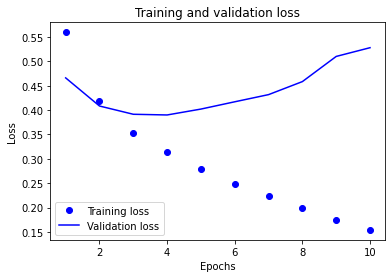

In [126]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

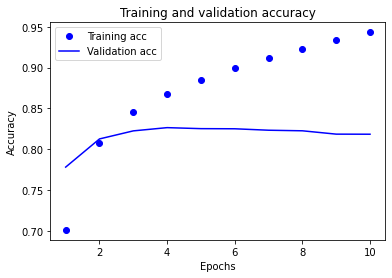

In [127]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



---



## 회고

총 3가지 구조의 모델, '1) LSTM, 2) Conv1D, 3) GlobalMaxPooling1D'를 사용하였고 한국어 word2vec 임베딩도 활용해봤다. 그러나 성능(val_acc) 면에서 큰 차이를 발견하지 못했다. 모델을 최적화하는 작업이 일정한 틀과 타당한 근거에 의한 것이 아니라 단순한 경험과 반복을 통해 이뤄지고 있다. 이에 대한 명확한 정립이 필요하다.